# 1 Predicting return from Gold:
## Background:
Gold has been the original store of value and medium of exchange for mankind for centuries till paper/or fiat currency took over a couple of centuries ago. However, most of the sustainable paper currencyies were backed by Gold as late as 1971, when the Bretton Woods agreement was scrapped and world currencies became a true $'Fiat'$ currency.

Gold however continues to be os interest not only as metal of choice for jewellery, but also as store of value and often advisable part of investment portfolio as it tends to be a hedge and safe haven when economies tend to (or atleat appear to) be in or at brink of collapse.

Currently there are numerous instruments which can give an investor exposure to Gold and they not necessarily need to keep it physically in their vaults. Exchange traded Funds (ETFs) is the most widely used instrument. As of April 2020, a total of USD175bn is invested in Gold ETFs across the globe. This was corpus was just USD24bn in 2008 before the Global Financial Crisis (GFC)

## Goal setting:
- Primary goal is to predict return from Gold prices using Machine learning. 
- We will use supervised learning methods of regression and classification. 
- We will then use Time Series methods. 
- Finally we will try to integrate them to see of their predictive powers increases due to integration.

## Project charter:

- First we will go the regression route to predict future returns of Gold over next 2 weeks and 3 weeks period. 
- We will do this by using historical returns of different instruments which I beleive impact or likely to impact the outlook towards Gold. 
- The fundamental reason is, I term Gold as a 'reactionary' asset. It has little fundamentals of its own and movement in prices is often is a derivative of how investors view other asset classes (equities and commdities).

In [1]:
#Importing Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

## 1.1: Retrieving and Preparing Data:
For this and subsequent exercises we will need closing price of several instruments for past 10 years . There are various paid (Reuters, Bloomberg) and free resources (IEX, Quandl, Yahoofinance, Google finance) that we can use to either extract and load data in csv or we can directly call their APIs. Since in this project I needed different type of asset classes (Equities, Commodities, Debt and precious metals)

In [2]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

- Now that we have the list, we need to define what date range we need to import the data for. 
- The period I have chosen is Jan 2010 till 30 Sept 2020. 
- The reason I did not pull data prior to that is because the GFC in 2008-09 massively changed the economic and market landscapes. Relationships pririo to that peirod might be of less relevance now. 
- I also dont want to feed very less data as the models might tend to overfit.

In [4]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-09-30"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
"""
Create a date-range and write it to an empty dataframe named values. Here I would extract and 
past the values pulled from yahoofinancials.
"""
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

- Once we have the date range in dataframe, we need to use ticker symbols to pull out data from the API. 
- yahoofinancials returns the output in a JSON format. 
- Below code loops over the the list of ticker symbols and extracts just the closing prices for all the historical dates and keeps them adding to the dataframe horizontally. 
- I have used the merge function to mantain the sanctity of dates. 
- These asset classes might have different regional and trading holidays, the date ranges are not bound to be the same.
- By merging, we will eventually have several NAs which we will frontfill later on.

In [5]:
from pandas import DataFrame 
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)

#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2804, 17)
Date                         0
Gold                       122
Silver                     122
Crude Oil                  121
S&P500                     100
Russel 2000 Index          100
10 Yr US T-Note futures    123
2 Yr US T-Note Futures     121
Platinum                   122
Copper                     122
Dollar Index               123
Volatility Index           100
Soybean                    147
MSCI EM ETF                100
Euro USD                   338
Euronext100                 59
Nasdaq                     100
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2799,2020-09-24,1868.300049,23.118000,40.310001,3246.590088,1451.819946,139.578003,110.426003,837.099976,2.9690,94.393997,28.510000,NaN,42.900002,1.167324,948.109985,10672.269531
2800,2020-09-25,1857.699951,23.017000,40.250000,3298.459961,1474.910034,139.641006,110.438004,841.099976,2.9730,94.681999,26.379999,NaN,42.939999,NaN,944.549988,10913.559570
2801,2020-09-28,1872.800049,23.528000,40.599998,3351.600098,1510.339966,139.625000,110.441002,881.900024,2.9895,94.302002,26.190001,NaN,43.419998,1.167883,965.710022,11117.530273
2802,2020-09-29,1894.300049,24.379999,39.290001,3335.469971,1504.729980,139.781006,110.445000,887.500000,2.9835,93.927002,26.270000,NaN,43.389999,1.174205,962.190002,11085.250000
2803,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2: Cleansing, integrating, and transforming data:

In [6]:
# Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [7]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2799,2020-09-24,1868.3,23.1,40.3,3246.6,1451.8,139.6,110.4,837.1,3.0,94.4,28.5,903.8,42.9,1.2,948.1,10672.3
2800,2020-09-25,1857.7,23.0,40.2,3298.5,1474.9,139.6,110.4,841.1,3.0,94.7,26.4,903.8,42.9,1.2,944.5,10913.6
2801,2020-09-28,1872.8,23.5,40.6,3351.6,1510.3,139.6,110.4,881.9,3.0,94.3,26.2,903.8,43.4,1.2,965.7,11117.5
2802,2020-09-29,1894.3,24.4,39.3,3335.5,1504.7,139.8,110.4,887.5,3.0,93.9,26.3,903.8,43.4,1.2,962.2,11085.2
2803,2020-09-30,1894.3,24.4,39.3,3335.5,1504.7,139.8,110.4,887.5,3.0,93.9,26.3,903.8,43.4,1.2,962.2,11085.2


In [8]:
values.to_csv("Reg_Training Data_Values.csv")

In [9]:
imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']

# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2804, 1)
(2804, 17)
(2804, 33)
(2804, 49)
(2804, 65)
(2804, 81)
(2804, 81)
(2804, 86)
(2804, 91)
(2804, 96)
(2804, 101)


- Besides just the lagged returns, we also see how far the current Gold price is from its moving average for with different window. 
- This is a very commonly used metric in technical analysis where moving averages offer supports and resistances for asset prices. 
- I will use a combination of simple and exponential moving averages. 

In [10]:
#Calculating Moving averages for Gold
ma = pd.DataFrame(values['Date'],columns=['Date'])
ma['Date']=pd.to_datetime(ma['Date'],format='%Y-%b-%d')
ma['15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
ma['30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
ma['60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
ma['90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
ma['180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
ma['90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
ma['180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
ma = ma.dropna(axis=0)
print(ma.shape)
ma.head()

(2625, 8)


,Date,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


## 1.3: Joining tables

In [11]:
# Add moving averages to the existing feature space.

from pandas import merge

print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = merge(left=data,right=ma,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2804, 101)
(2804, 108)


Date               0
Gold-T-1           1
Silver-T-1         1
Crude Oil-T-1      1
S&P500-T-1         1
                ... 
60SMA            179
90SMA            179
180SMA           179
90EMA            179
180EMA           179
Length: 108, dtype: int64

## 1.4: Setting target variables

- We are predicting returns here, so, we need to pick a horizon for which we need to predict the returns. 
- I have chosen 14-day and 22-day horizons because other smaller horizons tend to be very volatile and lack and predictive power. 

In [12]:
from pandas import DataFrame
#Caluculating forward returns for Target
y = DataFrame(data=values['Date'])
print(y.shape)
y['T+14']=values["Gold"].pct_change(periods=-14)
y['T+22']=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2804, 1)
(2804, 3)


Date     0
T+14    14
T+22    22
dtype: int64

##### Target variables here are the return percentages 

In [13]:
# Removing NAs
print(data.shape)
data = data[data['Gold-T-250'].notna()]
y = y[y['T+22'].notna()]
print(data.shape)
print(y.shape)

(2804, 108)
(2554, 108)
(2782, 3)


In [14]:
from pandas import merge
#Adding Target Variables
data = merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2532, 110)


Date             0
Gold-T-1         0
Silver-T-1       0
Crude Oil-T-1    0
S&P500-T-1       0
                ..
180SMA           0
90EMA            0
180EMA           0
T+14             0
T+22             0
Length: 110, dtype: int64

In [15]:
data.to_csv("Reg_Training Data_Values.csv",index=False)

#### Data is clean now and transformed to supervised ML algorithms

<IPython.core.display.Javascript object>

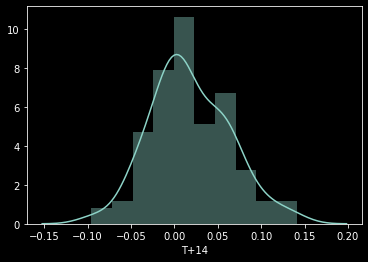

In [16]:
plt.style.use('dark_background')
corr = data.corr().iloc[:,-2:].drop(labels=['T+14','T+22'],axis=0)
sns.distplot(corr.iloc[:,0])
plt.show()

<IPython.core.display.Javascript object>

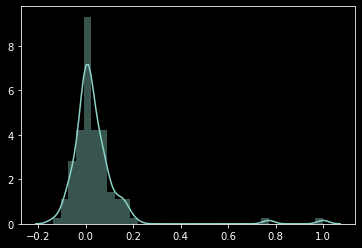

In [17]:
pd.set_option('display.max_rows', None)
corr_data = data.tail(2000).corr()
corr_data = pd.DataFrame(corr_data['T+14'])
#corr_data = corr_data.iloc[3:,]
corr_data = corr_data.sort_values('T+14',ascending=False)
#corr_data

sns.distplot(corr_data)
plt.show()

# 2. Regression:
I will use PyCaret machine learning library to automate the machine learning workflow and speed up the productivity.
## 2.1 22 Day Model:

In [18]:
from pycaret.regression import *
data_22= data.drop(['T+14'],axis=1)
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,T+22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.007675
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.011166
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.097983,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.030969
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.097701,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.034154
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.104046,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0.026404


In [19]:
a = setup(data_22,target='T+22',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=False);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed.


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2532, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [20]:
compare_models(turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,0.0124,0.0003,0.0169,0.8597,0.0154,-0.0336,0.9757
1,CatBoost Regressor,0.0132,0.0003,0.0176,0.8483,0.0160,-0.0629,13.6043
2,K Neighbors Regressor,0.0135,0.0003,0.0186,0.8303,0.0161,-0.1140,0.0315
3,Light Gradient Boosting Machine,0.0140,0.0003,0.0186,0.8301,0.0166,-0.0739,0.6611
4,Random Forest,0.0154,0.0004,0.0206,0.7918,0.0188,-0.0696,2.8708
5,Extreme Gradient Boosting,0.0163,0.0005,0.0216,0.7712,0.0190,-0.0331,0.8434
6,Gradient Boosting Regressor,0.0204,0.0007,0.0267,0.6506,0.0244,-0.2713,3.2286
7,Decision Tree,0.0207,0.0010,0.0309,0.5244,0.0217,-0.0760,0.1525
8,AdaBoost Regressor,0.0301,0.0014,0.0376,0.3076,0.0339,0.0125,1.1016
9,Bayesian Ridge,0.0309,0.0017,0.0406,0.1942,0.0335,-0.0325,0.0197


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=11, verbose=0, warm_start=False)

## 2.2 Model building: 
### 2.2.1 KNN:

In [21]:
print('creating knn model:')
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0127,0.0003,0.0174,0.8465,0.0146,0.0045
1,0.0142,0.0004,0.0199,0.7788,0.0174,0.3575
2,0.0134,0.0003,0.0179,0.8343,0.0156,-0.1506
3,0.0132,0.0004,0.0191,0.8318,0.0169,-0.7128
4,0.0129,0.0003,0.0180,0.8638,0.0153,-0.0511
5,0.0137,0.0003,0.0176,0.8477,0.0161,-0.1821
6,0.0137,0.0003,0.0184,0.8495,0.0164,-0.3526
7,0.0163,0.0005,0.0222,0.7999,0.0190,0.1849
8,0.0128,0.0003,0.0186,0.8136,0.0147,0.3985
9,0.0122,0.0003,0.0168,0.8374,0.0149,-0.6365


In [22]:
print('Tunning knn model:')
knn_tuned = tune_model(knn,n_iter=150)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0120,0.0003,0.0160,0.8699,0.0141,0.1621
1,0.0114,0.0003,0.0162,0.8529,0.0140,0.7800
2,0.0108,0.0002,0.0153,0.8782,0.0129,-0.5045
3,0.0120,0.0003,0.0171,0.8648,0.0145,0.0223
4,0.0109,0.0003,0.0164,0.8872,0.0128,-0.1274
5,0.0106,0.0002,0.0151,0.8877,0.0135,-0.0571
6,0.0108,0.0002,0.0157,0.8907,0.0141,-0.2890
7,0.0125,0.0003,0.0167,0.8867,0.0148,0.1940
8,0.0114,0.0003,0.0161,0.8595,0.0131,-0.1698
9,0.0093,0.0002,0.0129,0.9038,0.0118,-0.7289


### 2.2.2 CatBoost:

In [23]:
print('creating catboost model:')
catb = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0132,0.0003,0.0179,0.8379,0.0163,0.0569
1,0.0133,0.0003,0.0180,0.8183,0.0168,0.0790
2,0.0117,0.0002,0.0158,0.8704,0.0146,-0.3468
3,0.0132,0.0003,0.0176,0.8572,0.0161,-0.5310
4,0.0146,0.0004,0.0190,0.8476,0.0173,0.1549
5,0.0131,0.0003,0.0171,0.8564,0.0159,0.0141
6,0.0133,0.0003,0.0187,0.8445,0.0162,-0.4330
7,0.0133,0.0003,0.0184,0.8617,0.0167,0.3035
8,0.0138,0.0003,0.0180,0.8256,0.0161,0.5472
9,0.0122,0.0002,0.0154,0.8632,0.0140,-0.4735


In [24]:
catb_tuned = tune_model(catb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0145,0.0004,0.0194,0.8089,0.0173,-0.0298
1,0.0128,0.0003,0.0184,0.8103,0.0167,-0.1734
2,0.0116,0.0002,0.0154,0.8772,0.0142,-1.0735
3,0.0139,0.0003,0.0182,0.8464,0.0166,-0.8532
4,0.0151,0.0004,0.0203,0.8274,0.0181,0.0045
5,0.0139,0.0003,0.0182,0.8372,0.0167,0.0110
6,0.0138,0.0003,0.0186,0.8466,0.0168,-0.5678
7,0.0147,0.0004,0.0196,0.8430,0.0173,0.4501
8,0.0138,0.0003,0.0178,0.8298,0.0163,1.0161
9,0.0117,0.0002,0.0150,0.8706,0.0133,-0.4421


### 2.2.3 ExtraTree:

In [25]:
print('creating extratree model:')
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0128,0.0003,0.0171,0.8523,0.0155,0.0681
1,0.0127,0.0003,0.0176,0.8262,0.0162,-0.0691
2,0.0111,0.0002,0.0148,0.8857,0.0134,-0.1808
3,0.0119,0.0003,0.0165,0.8733,0.0151,-0.1823
4,0.0128,0.0003,0.0175,0.8705,0.0157,0.0566
5,0.0131,0.0003,0.0171,0.8555,0.0159,0.0471
6,0.0125,0.0003,0.0186,0.8466,0.0168,-0.2316
7,0.0130,0.0003,0.0183,0.8632,0.0169,0.2680
8,0.0126,0.0003,0.0170,0.8437,0.0156,0.1217
9,0.0111,0.0002,0.0145,0.8797,0.0132,-0.2335


In [26]:
et_tuned = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0154,0.0004,0.0211,0.7743,0.0189,0.0438
1,0.0160,0.0005,0.0218,0.7339,0.0202,-0.1482
2,0.0129,0.0003,0.0175,0.8416,0.0161,-0.2451
3,0.0150,0.0004,0.0210,0.7964,0.0192,-0.1287
4,0.0172,0.0006,0.0235,0.7684,0.0207,0.0479
5,0.0155,0.0005,0.0214,0.7739,0.0201,0.0321
6,0.0150,0.0005,0.0220,0.7839,0.0200,-0.1761
7,0.0167,0.0005,0.0233,0.7797,0.0213,0.2500
8,0.0150,0.0004,0.0207,0.7684,0.0191,0.3069
9,0.0142,0.0004,0.0189,0.7944,0.0174,-0.5039


## 2.3 Model evaluation:

In [27]:
evaluate_model(knn_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [28]:
evaluate_model(et_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## 2.4 Ensembling Models:

In [32]:
et_bagged = ensemble_model(et,method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0159,0.0005,0.0213,0.7701,0.0193,-0.0291
1,0.0160,0.0005,0.0215,0.7417,0.0200,0.0406
2,0.0136,0.0003,0.0178,0.8357,0.0165,-0.2428
3,0.0151,0.0004,0.0209,0.7980,0.0193,-0.0730
4,0.0172,0.0005,0.0229,0.7793,0.0211,0.0760
5,0.0161,0.0004,0.0210,0.7819,0.0198,0.0160
6,0.0161,0.0005,0.0227,0.7708,0.0207,-0.1869
7,0.0174,0.0006,0.0235,0.7757,0.0217,0.1863
8,0.0160,0.0004,0.0210,0.7618,0.0195,0.2720
9,0.0146,0.0003,0.0187,0.7990,0.0174,-0.6514


In [33]:
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0112,0.0002,0.0149,0.8875,0.0135,0.1158
1,0.0117,0.0003,0.0167,0.8428,0.0149,0.5212
2,0.0111,0.0002,0.0153,0.8777,0.0136,-0.5185
3,0.0113,0.0003,0.0168,0.8691,0.0146,-0.6350
4,0.0112,0.0003,0.0171,0.8766,0.0124,-0.1538
5,0.0116,0.0002,0.0155,0.8814,0.0143,-0.1220
6,0.0112,0.0003,0.0159,0.8877,0.0141,-0.2574
7,0.0126,0.0003,0.0170,0.8821,0.0146,0.1435
8,0.0109,0.0002,0.0154,0.8729,0.0122,0.2395
9,0.0096,0.0002,0.0130,0.9028,0.0118,-0.8773


## 2.5 Blending Models:

In [34]:
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0115,0.0002,0.0151,0.8836,0.0137,0.1359
1,0.0107,0.0002,0.0150,0.8737,0.0137,0.3840
2,0.0098,0.0002,0.0132,0.9088,0.0115,-0.2146
3,0.0105,0.0002,0.0151,0.8940,0.0131,-0.0217
4,0.0108,0.0002,0.0148,0.9072,0.0128,-0.0276
5,0.0109,0.0002,0.0143,0.8992,0.0133,0.0461
6,0.0100,0.0002,0.0147,0.9032,0.0135,-0.2499
7,0.0113,0.0002,0.0155,0.9023,0.0141,0.2150
8,0.0102,0.0002,0.0143,0.8898,0.0123,-0.0135
9,0.0092,0.0001,0.0120,0.9172,0.0111,-0.4700


In [49]:
stack1 = stack_models(estimator_list=[catb,knn_tuned],restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0110,0.0002,0.0150,0.8857,0.0128,-0.0747
1,0.0100,0.0002,0.0141,0.8886,0.0127,0.6223
2,0.0103,0.0002,0.0137,0.9026,0.0121,-0.4067
3,0.0107,0.0002,0.0149,0.8974,0.0132,-0.1257
4,0.0106,0.0002,0.0143,0.9144,0.0119,-0.0942
5,0.0103,0.0002,0.0140,0.9040,0.0131,-0.0595
6,0.0106,0.0002,0.0144,0.9083,0.0129,-0.4688
7,0.0103,0.0002,0.0144,0.9161,0.0127,0.4642
8,0.0100,0.0002,0.0134,0.9038,0.0113,-0.1358
9,0.0092,0.0001,0.0119,0.9185,0.0109,-0.8691


In [50]:
stack2 = stack_models(estimator_list=[catb,et,knn_tuned], meta_model = blend_knn_et, restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0104,0.0002,0.0142,0.8970,0.0126,0.2148
1,0.0096,0.0002,0.0140,0.8902,0.0125,0.0462
2,0.0095,0.0002,0.0131,0.9101,0.0114,-0.4061
3,0.0105,0.0002,0.0146,0.9008,0.0125,0.1378
4,0.0097,0.0002,0.0139,0.9182,0.0118,-0.0647
5,0.0097,0.0002,0.0135,0.9104,0.0125,0.0208
6,0.0095,0.0002,0.0137,0.9163,0.0125,-0.3512
7,0.0106,0.0002,0.0141,0.9193,0.0126,0.2935
8,0.0096,0.0002,0.0135,0.9020,0.0113,0.0328
9,0.0085,0.0001,0.0116,0.9228,0.0106,-0.4930


In [52]:
stack3 = stack_models(estimator_list=[catb,et,knn_tuned,blend_knn_et], restack=True,meta_model=blend_knn_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0106,0.0002,0.0144,0.8954,0.0127,0.2134
1,0.0098,0.0002,0.0142,0.8872,0.0126,0.0247
2,0.0095,0.0002,0.0132,0.9097,0.0114,-0.3542
3,0.0106,0.0002,0.0149,0.8970,0.0128,-0.1059
4,0.0097,0.0002,0.0139,0.9188,0.0118,-0.0558
5,0.0096,0.0002,0.0134,0.9121,0.0124,0.0465
6,0.0097,0.0002,0.0138,0.9148,0.0126,-0.3188
7,0.0107,0.0002,0.0143,0.9171,0.0128,0.2692
8,0.0097,0.0002,0.0137,0.8983,0.0114,0.0321
9,0.0084,0.0001,0.0115,0.9240,0.0106,-0.5108


In [53]:
save_model(model=stack2, model_name='22Day Regressor')

Transformation Pipeline and Model Succesfully Saved


# 3 14 Day Model:

In [54]:
data_14= data.drop(['T+22'],axis=1)
data_14.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,T+14
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.097983,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.010555
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.097701,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.002023
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.104046,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,-0.004113


In [55]:
c=setup(data_14,target='T+14',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=True);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed.


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2532, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [57]:
compare_models(turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,0.0124,0.0003,0.0171,0.7549,0.0158,0.0093,1.0174
1,CatBoost Regressor,0.0126,0.0003,0.0174,0.7451,0.0159,-0.0090,14.6136
2,K Neighbors Regressor,0.0125,0.0003,0.0176,0.7383,0.0150,-0.1484,0.0295
3,Light Gradient Boosting Machine,0.0134,0.0004,0.0187,0.7032,0.0166,0.0343,0.7415
4,Random Forest,0.0151,0.0004,0.0209,0.6342,0.0193,-0.0277,2.4350
5,Extreme Gradient Boosting,0.0151,0.0004,0.0210,0.6282,0.0178,-0.0022,0.7116
6,Gradient Boosting Regressor,0.0184,0.0006,0.0241,0.5098,0.0219,-0.0518,4.4389
7,AdaBoost Regressor,0.0242,0.0010,0.0309,0.1950,0.0280,-0.0419,1.2651
8,Decision Tree,0.0210,0.0010,0.0311,0.1720,0.0213,-0.0155,0.1344
9,Bayesian Ridge,0.0246,0.0011,0.0328,0.0932,0.0274,-0.0110,0.0168


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=11, verbose=0, warm_start=False)

In [59]:
knn_tuned = tune_model(knn,n_iter=150)
catb = create_model('catboost')
et = create_model('et')
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0091,0.0001,0.0120,0.8617,0.0107,-0.1955
1,0.0119,0.0003,0.0168,0.8359,0.0147,-0.5136
2,0.0100,0.0002,0.0127,0.8360,0.0115,-0.0172
3,0.0091,0.0002,0.0123,0.8695,0.0116,-0.2479
4,0.0091,0.0002,0.0126,0.8531,0.0116,-0.8030
5,0.0103,0.0002,0.0154,0.7984,0.0146,0.2326
6,0.0103,0.0002,0.0136,0.8543,0.0121,-0.3512
7,0.0118,0.0003,0.0186,0.7474,0.0166,-0.0060
8,0.0101,0.0002,0.0134,0.8521,0.0115,0.0603
9,0.0089,0.0001,0.0120,0.8503,0.0110,-0.1770


In [60]:
stack1 = stack_models(estimator_list=[catb,blend_knn_et],restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0082,0.0001,0.0107,0.8902,0.0091,-0.3526
1,0.0092,0.0002,0.0138,0.8890,0.0121,-0.4464
2,0.0104,0.0002,0.0134,0.8180,0.0120,0.2545
3,0.0087,0.0001,0.0116,0.8844,0.0107,-0.1726
4,0.0086,0.0001,0.0110,0.8893,0.0100,-0.1324
5,0.0085,0.0001,0.0121,0.8762,0.0114,0.5557
6,0.0093,0.0002,0.0126,0.8754,0.0109,-0.3986
7,0.0108,0.0003,0.0171,0.7859,0.0151,0.1774
8,0.0092,0.0001,0.0119,0.8834,0.0100,0.1617
9,0.0087,0.0001,0.0117,0.8576,0.0099,-0.2561


In [61]:
stack2 = stack_models(estimator_list=[catb,blend_knn_et], restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0082,0.0001,0.0107,0.8902,0.0091,-0.3526
1,0.0092,0.0002,0.0138,0.8890,0.0121,-0.4464
2,0.0104,0.0002,0.0134,0.8180,0.0120,0.2545
3,0.0087,0.0001,0.0116,0.8844,0.0107,-0.1726
4,0.0086,0.0001,0.0110,0.8893,0.0100,-0.1324
5,0.0085,0.0001,0.0121,0.8762,0.0114,0.5557
6,0.0093,0.0002,0.0126,0.8754,0.0109,-0.3986
7,0.0108,0.0003,0.0171,0.7859,0.0151,0.1774
8,0.0092,0.0001,0.0119,0.8834,0.0100,0.1617
9,0.0087,0.0001,0.0117,0.8576,0.0099,-0.2561


In [62]:
save_model(model=stack2, model_name='14Day Regressor')

Transformation Pipeline and Model Succesfully Saved


# Deploy model on Google Cloud Platform (GCP)

In [30]:
#import os
# Upload model
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'c:/path-to-json-file.json'from pycaret.regression import deploy_model
#deploy_model(model = model, model_name = 'model-name', platform = 'gcp', 
             #authentication = {'project' : 'project-name', 'bucket' : 'bucket-name'})

In [31]:
#import os
# access the model from the GCP bucket
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'c:/path-to-json-file.json'from pycaret.regression import load_model
#loaded_model = load_model(model_name = 'model-name', platform = 'gcp', 
                          #authentication = {'project' : 'project-name', 'bucket' : 'bucket-name'})from pycaret.regression import predict_model
#predictions = predict_model(loaded_model, data = new-dataframe)